In [3]:
'''
Much of this code is adapted from https://github.com/capellaspace/jupyter-notebooks/blob/master/Capella-Time-Series-GIF-Example.ipynb
'''
import rasterio
import numpy as np
from matplotlib import rcParams
from matplotlib import pyplot
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

import warnings
warnings.filterwarnings('ignore')

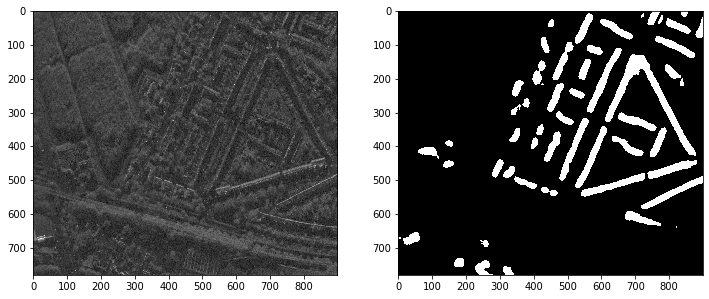

In [6]:
Session = rasterio.Env(
            GDAL_DISABLE_READDIR_ON_OPEN='YES',
            CPL_VSIL_CURL_USE_HEAD='NO',
            )
FILTSIZE = 3 # For speckle filtering
rcParams['figure.figsize'] = 12, 7

def lee_filter(img, size):
    ''' Apply speckle filtering to SAR image '''
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

fig, ax = plt.subplots(1, 2)

# Visualize SAR test image
fp1 = 'test_public/AOI_11_Rotterdam/SN6_Test_Public_AOI_11_Rotterdam_SAR-Intensity_20190804111851_20190804112030_tile_5180.tif'
src1 = rasterio.open(fp1)
img1 = src1.read(4) # Get 4th band (most coherent in this case)
img1 = img1[:780] # Crop
img1 = lee_filter(img1, FILTSIZE)
ax[0].imshow(img1, 'gray')

# Visualize building footprint mask
fp2 = 'inference_continuous/SN6_Test_Public_AOI_11_Rotterdam_SAR-Intensity_20190804111851_20190804112030_tile_5180.tif'
src2 = rasterio.open(fp2)
img2 = src2.read(1)[:780] # Crop
# Convert to binary
img2[img2 < 0] = 0
img2[img2 > 0] = 1
ax[1].imshow(img2, 'gray')

plt.show()